In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split as sk_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import re
import datetime

In [195]:
# Load datasets
ratings = pd.read_csv('movie_lense/ratings.csv')
print ('Shape of the ratings data frame:', ratings.shape)

tags = pd.read_csv('movie_lense/tags.csv')
print ('Shape of the tags data frame:', tags.shape)

movies = pd.read_csv('movie_lense/movies.csv')
print ('Shape of the movies data frame:', movies.shape)

#Will take
tags = tags.sample(frac=0.2)
ratings = ratings.sample(frac=0.2)

print ('Shape of the sampled ratings data frame:', ratings.shape)
print ('Shape of the sampled tags data frame:', tags.shape)
print ('Shape of the sampled movies data frame:', movies.shape)

Shape of the ratings data frame: (27753444, 4)
Shape of the tags data frame: (1108997, 4)
Shape of the movies data frame: (58098, 3)
Shape of the sampled ratings data frame: (5550689, 4)
Shape of the sampled tags data frame: (221799, 4)
Shape of the sampled movies data frame: (58098, 3)


In [196]:
#Print sample ratings data
ratings.head(n=5)

,userId,movieId,rating,timestamp
7731039,79637,2948,4.0,1022307390
4200350,43149,367,4.0,974764166
6616374,67910,1487,3.0,1168294769
4565213,46953,8169,3.0,1329071086
15399463,157372,53322,4.0,1309045005


In [197]:
#Display summary statistics about data
ratings.describe()

,userId,movieId,rating,timestamp
count,5.550689e+06,5.550689e+06,5.550689e+06,5.550689e+06
mean,1.418958e+05,1.850095e+04,3.529917e+00,1.193136e+09
std,8.168783e+04,3.511208e+04,1.066481e+00,2.160497e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.116400e+04,1.100000e+03,3.000000e+00,9.986027e+08
50%,1.419700e+05,2.716000e+03,3.500000e+00,1.174219e+09
75%,2.123760e+05,7.153000e+03,4.000000e+00,1.422756e+09
max,2.832280e+05,1.938820e+05,5.000000e+00,1.537945e+09


In [198]:
#Print sample tags data
tags.head(n=5)

,userId,movieId,tag,timestamp
193659,58557,79293,terrible acting,1304705931
552983,103013,8015,surreal,1247104062
156532,47960,122886,Adam Driver,1459459171
276955,73406,132,san francisco,1527452294
444861,73406,168740,unfaithful husband,1527220858


In [199]:
#Print sample movies data
movies.head(n=5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Drop timestamp data from ratings as the time a movie was rates is not relevant for our purposes. We will keep the timestamp for tags however for two reasons:

Different tags might be associated with a movie by the same user at the same time. Therefore if we split the database randomly, we could create a data leak where it would be easier for the algorithm to predict movie rating.
Instead we will use time to split the data set into training and test datasets. This would be very applicable to a real world scenario where we have past data and we would like to predict ratings in the future for the users. 

In [200]:
ratings = ratings.drop(['timestamp'], axis=1)

We will merge tags and ratings data using inner join as the aim of our project is to determine how accurately we can predict movie rating using tags. Therefore we will not use ratings data without any tags.

In [201]:

data = pd.merge(ratings, tags, how='inner')
print ('Shape of the joint data frame:', data.shape)
print (data.head(n=5))


Shape of the joint data frame: (33546, 5)
   userId  movieId  rating       tag   timestamp
0   88574   112591     4.5  Afrobeat  1466954908
1  222734    59604     4.5   tragedy  1309079628
2  222734    59604     4.5    horror  1309061592
3  222734    59604     4.5     drama  1309061610
4  222734    59604     4.5     abuse  1309061597


# Clean, Process and Examine Data

In [202]:
for column in data.columns:
    print (column, data[column].nunique())

userId 4591
movieId 6614
rating 10
tag 9164
timestamp 32668


We can see that there are 6500 unique users, 8500 movies and 13800 tags. 
There are also 10 available ratings a user can give which makes it possible for us to use classification methods. If there were alot more unique ratings so that target variable is continuous, we could have used regression models. 

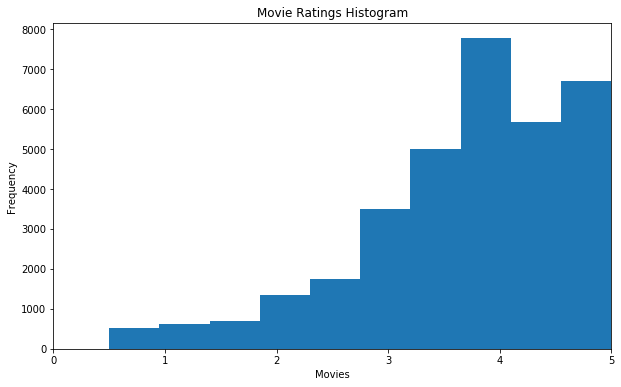

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(data['rating'],10)
plt.xlabel('Movies'); 
plt.ylabel('Frequency')
plt.xlim(0,5)
plt.title('Movie Ratings Histogram')
plt.show()

We can see from the histogram plot that the most frequent movie rating given is 4. 
This also results in an unbalanced target variable, therefore we will need to address this during machine learning. 

Let's visualize tags by average rating to see if get an initial feeling whether tags would be a good predictor variable.



In [204]:
#Compute average ratings by tag
tagratings = pd.pivot_table(data, values=['rating'], columns=['tag'], aggfunc='mean')
tagratings

tag,"""found footage""","""potty"" jokes",#exorcism,'Heads Or Tails...Call It','I Can't Get That Theme Song Out Of My Head','I Will Give My Kingdom For A Great Piece Of TWAT!','Oh The Whore-ror!',(s)vcd,*Good* Musicals,+++++++++++++++,...,yugo,yuppies,zeitgeist-y,zero gravity,zizek,zombie,zombie apocalypse,zombies,oppl,惊悚
rating,4.166667,3.5,4.0,4.0,3.5,0.5,4.0,4.0,3.0,1.5,...,3.5,3.5,4.0,4.5,4.5,3.5,1.0,3.488636,4.0,4.0


We can see that some tags have higher average ratings than others. We can also see that there are special characters that we can remove to have less number of unique tags and improve our performance. 

In [205]:
#Remove any special characters from tag
#Relabel ratings 
data['rating'] = data['rating'].apply(lambda x: 1 if x > 4 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x))
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
data['tag'] = data['tag'].str.lower()

In [206]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tag'])
sequences = tokenizer.texts_to_sequences(data['tag'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

Found 7648 unique tokens.


In [207]:
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['timestamp'].astype('datetime64[ns]')

0       2016-06-26 08:28:28
1       2011-06-26 02:13:48
2       2011-06-25 21:13:12
3       2011-06-25 21:13:30
4       2011-06-25 21:13:17
                ...        
33541   2018-04-25 06:50:11
33542   2018-04-25 06:50:05
33543   2010-04-10 19:56:52
33544   2010-04-10 19:57:00
33545   2009-05-20 16:20:50
Name: timestamp, Length: 33546, dtype: datetime64[ns]

In [208]:
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = data['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()

words = vectorizer.get_feature_names()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(wordvec,columns=words)

number of words in plot summary:  7455


In [209]:
data.shape

(33546, 5)

# K-Means Clustering Words using Glove Embeddings

Load Stanford's global word embeddings as pre-trained model. Since we do not have a lot of text data to create our own embeddings as tags are comprised of few words , it makes sense to use a pre-trained word embedding model.

In [210]:
embeddings_index = {}
f = open('movie_lense/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(words), 100))
for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


In [211]:

reduced_data = PCA(n_components=2).fit_transform(pdembedding.T)
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


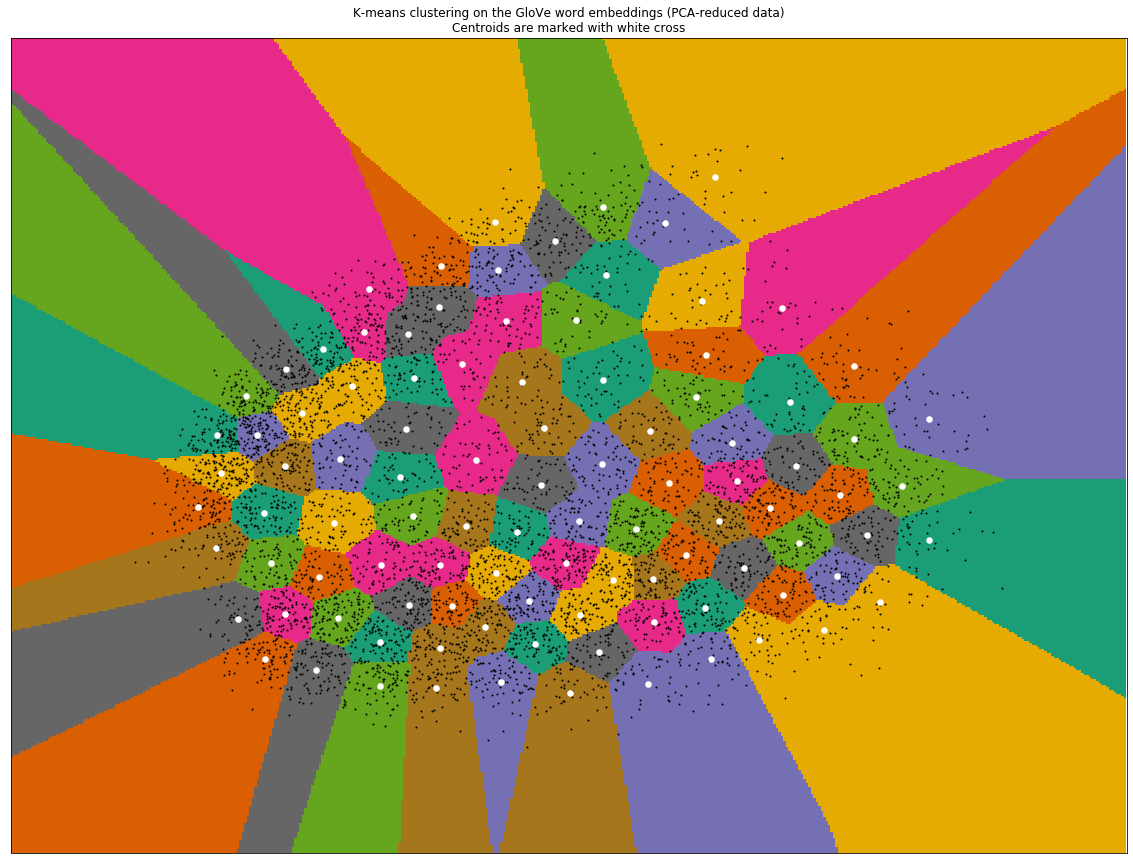

In [212]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Dark2,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='.', s=50, linewidths=3,
            color='w', zorder=10)

plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [188]:
test_user = tags.iloc[0]
test_user['tag']

'protest'

In [213]:
kmeans.predict(test_user['tag'])

ValueError: could not convert string to float: 'protest'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24535 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 21169 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 24535 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29420 missing from curre

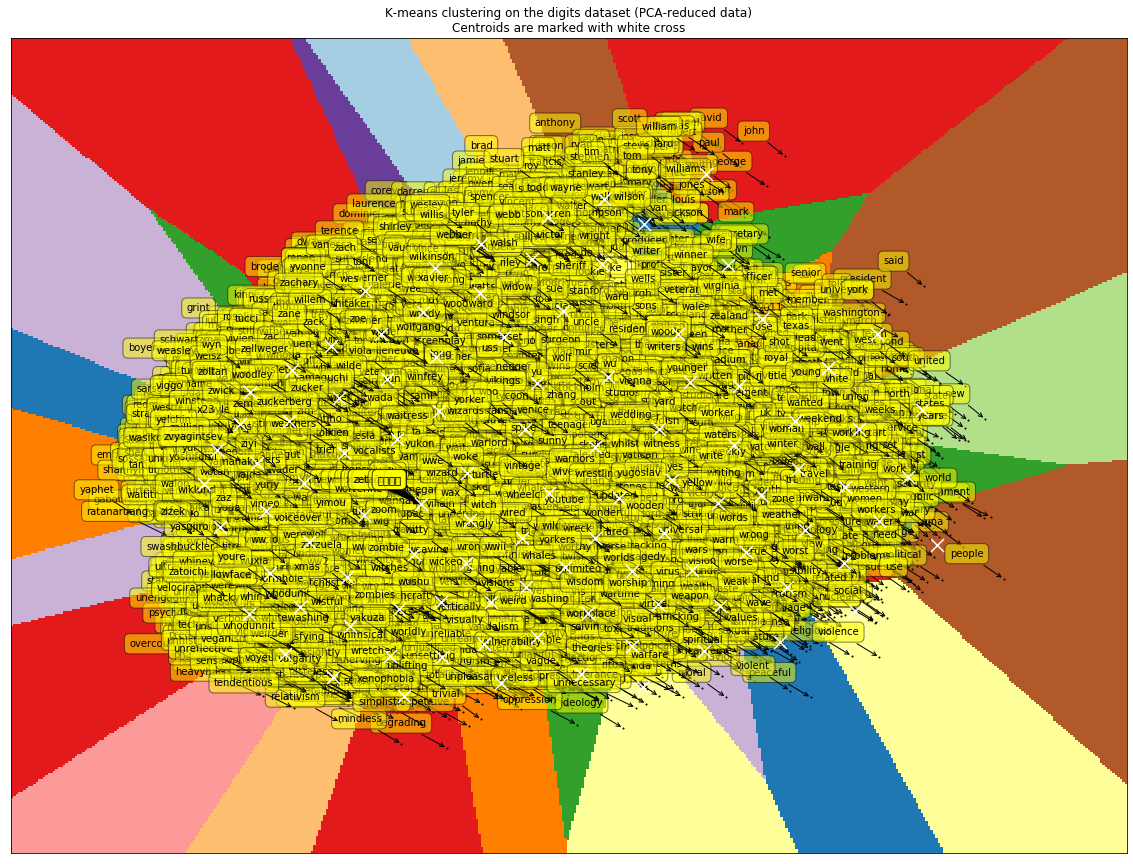

In [52]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

The accuracy of logistic regression model is higher than the baseline model. Let's see if we can increase the performance using different regularization parameters. 